In [1]:
import pandas as pd
import os
from datetime import datetime
import numpy as np
from sklearn.impute import SimpleImputer
from typing import Tuple, Union
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import plotly.express as px

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#initate plotly
pyoff.init_notebook_mode()

In [2]:
#Settings display pandas
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
#Some functions uses in this notebook
def shape(df: pd.DataFrame)-> str:
    return f"le jeu de données a : {df.shape[0]} lignes et {df.shape[1]} colonnes"

def missingValues(df: pd.DataFrame):
    print("NaN in each columns ",df.isnull().sum().sort_values(ascending = False),sep='\n')
    
def display_distribution(df: pd.DataFrame,
                         numerical_cols: list):

    plt.figure(figsize=(20,8))
    i = 0
    for column_ in numerical_cols:
        i = i+ 1
        plt.subplot(2, 2, i)
        sns.distplot(df[column_], label='Data', hist=False)
        plt.legend()
        plt.xlabel(numerical_cols[i-1], fontsize=12)
    
def describeT(df: pd.DataFrame)-> pd.DataFrame:
    return df.describe(include='all').T

#Correlation matrix
def corr_matrix(df: pd.DataFrame,
                statistique_test: Union[None,str]='pearson'):
    plt.figure(figsize=(10,10))
    sns.heatmap(df.corr(statistique_test),
                cmap=plt.cm.RdBu,
                vmax=1.0,
                linewidths=0.1,
                linecolor='white',
                square=True,
                annot=True
                )
    
#Select a kind of features
#kind : [number,int,float64,category,datetimetz]
def selectKindFeatures(df: pd.DataFrame,
                       kind: Union[None,str]='number')-> Union[str,pd.DataFrame]:
    if len(df.select_dtypes(include=kind).columns) == 0:
        return f"Le dataframe ne contient pas de variables {kind}"
    return df.select_dtypes(include=kind)

def pair_plot(df: pd.DataFrame,
              numerical_cols: list,
              target: Union[None,str]=None):
    plt.figure(figsize=(10,10))
    if target is not None:
        numerical_cols.append(target)
        sns.pairplot(df[numerical_cols],height = 2, hue=target)
    else:
        sns.pairplot(df[numerical_cols],height = 2)
        
# Boxplot
def display_stackedboxplot(df: pd.DataFrame,
                    numerical_cols: list,
                    target: str):
    plt.figure(figsize=(20,8))
    i = 0
    for columns_ in numerical_cols:
        i = i+1
        plt.subplot(2, 2, i)
        sns.boxplot(x=df[target], y=df[columns_], data=df, palette = "viridis")

# Boxplot
def display_boxplot(df: pd.DataFrame,
                    numerical_cols: list):
    plt.figure(figsize=(20,8))
    i = 0
    for columns_ in numerical_cols:
        i = i+1
        plt.subplot(2, 2, i)
        sns.boxplot(x=df[columns_], data=df, palette='viridis')

#import plotly.io as pio
#pio.renderers.default='notebook'
def display_scatterPlotlyTarget(df: pd.DataFrame,col_x: str,
                  col_y: str,Path: Union[None,str]=str(os.getcwd()),
                  save: bool=False):
    assert(len(df[col_y].unique())) == 2, 'target with cardinality equal 2 is required, I recommend to use the stackedBarPlotSeaborn'
    col_y_bool = col_y+"_bool"
    fig_title = f"{col_x} in terms of {col_y} Rate"
    df[col_y_bool] = np.where(df[col_y]=="No",0,1)
    df_grouped = df.groupby(col_x)[col_y_bool].mean().reset_index()
    plot_data = px.scatter(x=df_grouped[col_x],
                           y=df_grouped[col_y_bool],
                          title=fig_title)
    plot_data.update_layout(xaxis=dict(title_text=f'{col_x}'),
                            yaxis=dict(title_text=f'{col_y}_rate'))
    
    plot_data.show()
    
    if save==True and Path is not None:
        figname = fig_title.replace(" ","_")
        figure.write_image(f"{Path}/{figname}.png")

def display_stackedBarPlotSeaborn(df: pd.DataFrame,col_x: str,
                   col_y: str,save: bool=False,
                   Path: Union[None,str]=str(os.getcwd())):
    
    Total = df.shape[0]
    df_cross = pd.crosstab(df[col_x],df[col_y])
    fig = plt.figure(figsize=(11,6))
    # now stack and reset
    stacked = df_cross.stack().reset_index().rename(columns={0:'value'})
    
    # plot grouped bar chart
    splot = sns.barplot(x=stacked[col_x], y=stacked['value'], hue=stacked[col_y])
    title = f"{col_x} in terms of {col_y} value"
    splot.set_title(title)

    for p in splot.patches:
        splot.annotate(format((p.get_height()/Total), '.3f'),
                       (p.get_x()+ p.get_width()/ 2., p.get_height()),
                       ha = 'center',
                       va = 'center',
                       xytext = (0, 7),
                       textcoords = 'offset points')
        
    if save and Path is not None:
        figname = title.replace(" ","_")
        fig.savefig(f"{Path}/{figname}.png")

def display_stackedBarplotPlotly(df: pd.DataFrame,col_x: str,
                        col_y: str,save: bool=False,
                        Path: Union[None,str]=str(os.getcwd())):
    assert(len(df[col_y].unique())) == 2, 'at least target with cardinality equal 2 is required, I recommend to use the stackedBarPlotSeaborn'
    col_y_bool = col_y+"_bool"
    fig_title = f"{col_x} in terms of {col_y} Rate"
    df[col_y_bool] = np.where(df[col_y]=="No",0,1)
    df_grouped = df.groupby(col_x)[col_y_bool].mean().reset_index()
    plot_data = px.bar(x=df_grouped[col_x],
                       y=df_grouped[col_y_bool],
                      color=df_grouped[col_x])
    
    plot_data.update_layout(xaxis=dict(title_text=f'{col_x}'),
                            yaxis=dict(title_text=f'{col_y}_rate'))
    
    plot_data.show()
    
    if save and Path is not None:
        figname = fig_title.replace(" ","_")
        figure.write_image(f"{Path}/{figname}.png")
        
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [4]:
#Read data
df_data = pd.read_csv('Data/churn.csv')
df_data.head(10)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges Churn
0  7590-VHVEG  Female              0     Yes         No       1           No  No phone service             DSL             No          Yes               No          No          No              No  Month-to-month              Yes           Electronic check           29.85        29.85    No
1  5575-GNVDE    Male              0      No         No      34          Yes                No             DSL            Yes           No              Yes          No          No              No        One year               No               Mailed check           56.95       1889.5    No
2  3668-QPYBK    Male              0      No         No       2          Yes                No             DSL            Yes          Yes               No          No          No              No  Month-to-month              Yes               Mailed check           53.85       108.15   Yes
3  7795-CFOCW    Male              0      No         No      45           No  No phone service             DSL            Yes           No              Yes         Yes          No              No        One year               No  Bank transfer (automatic)           42.30      1840.75    No
4  9237-HQITU  Female              0      No         No       2          Yes                No     Fiber optic             No           No               No          No          No              No  Month-to-month              Yes           Electronic check           70.70       151.65   Yes
5  9305-CDSKC  Female              0      No         No       8          Yes               Yes     Fiber optic             No           No              Yes          No         Yes             Yes  Month-to-month              Yes           Electronic check           99.65        820.5   Yes
6  1452-KIOVK    Male              0      No        Yes      22          Yes               Yes     Fiber optic             No          Yes               No          No         Yes              No  Month-to-month              Yes    Credit card (automatic)           89.10       1949.4    No
7  6713-OKOMC  Female              0      No         No      10           No  No phone service             DSL            Yes           No               No          No          No              No  Month-to-month               No               Mailed check           29.75        301.9    No
8  7892-POOKP  Female              0     Yes         No      28          Yes               Yes     Fiber optic             No           No              Yes         Yes         Yes             Yes  Month-to-month              Yes           Electronic check          104.80      3046.05   Yes
9  6388-TABGU    Male              0      No        Yes      62          Yes                No             DSL            Yes          Yes               No          No          No              No        One year               No  Bank transfer (automatic)           56.15      3487.95    No

In [5]:
#Shape
shape(df_data)

'le jeu de données a : 7043 lignes et 21 colonnes'

In [6]:
#MonthlyCharges type is float64 but TotalCharges is object. so let's convert it
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
#In my opinion this method is better than .astype(float) or float(df_data.TotalCharges)
#Because it convert all data he can then put NaN values when it don't works thanks the 'coerce errors parameter value'
#If we use for example astype(float), an error raise that he can't convert some character in the column (the blank value)
df_data['TotalCharges'] = pd.to_numeric(df_data['TotalCharges'],errors='coerce')

In [8]:
#Or bool
df_data['SeniorCitizen'] = df_data['SeniorCitizen'].astype(object)

In [9]:
#11 NaN values corresponding to the whitespace values in column
missingValues(df_data)

NaN in each columns 
TotalCharges        11
Churn                0
OnlineSecurity       0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
customerID           0
dtype: int64


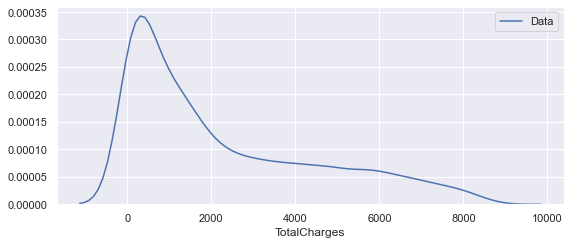

In [10]:
#Let's see distribution of TotalCharges
#Right skewed : Beware of that kind of features if with use some models with the assumption of normalized features (LR)
display_distribution(df_data,['TotalCharges'])

In [11]:
#Replace NaN values by the median
imp = SimpleImputer(missing_values=np.nan, strategy='median')
df_data['TotalCharges'] = imp.fit_transform(df_data[['TotalCharges']]).ravel()

In [12]:
#Display the median values
med = np.median(df_data['TotalCharges'])
df_data.query(f"TotalCharges == {med}")

customerID  gender SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService       OnlineSecurity         OnlineBackup     DeviceProtection          TechSupport          StreamingTV      StreamingMovies  Contract PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges Churn
488   4472-LVYGI  Female             0     Yes        Yes       0           No  No phone service             DSL                  Yes                   No                  Yes                  Yes                  Yes                   No  Two year              Yes  Bank transfer (automatic)           52.55      1397.475    No
753   3115-CZMZD    Male             0      No        Yes       0          Yes                No              No  No internet service  No internet service  No internet service  No internet service  No internet service  No internet service  Two year               No               Mailed check           20.25      1397.475    No
936   5709-LVOEQ  Female             0     Yes        Yes       0          Yes                No             DSL                  Yes                  Yes                  Yes                   No                  Yes                  Yes  Two year               No               Mailed check           80.85      1397.475    No
1082  4367-NUYAO    Male             0     Yes        Yes       0          Yes               Yes              No  No internet service  No internet service  No internet service  No internet service  No internet service  No internet service  Two year               No               Mailed check           25.75      1397.475    No
1340  1371-DWPAZ  Female             0     Yes        Yes       0           No  No phone service             DSL                  Yes                  Yes                  Yes                  Yes                  Yes                   No  Two year               No    Credit card (automatic)           56.05      1397.475    No
3331  7644-OMVMY    Male             0     Yes        Yes       0          Yes                No              No  No internet service  No internet service  No internet service  No internet service  No internet service  No internet service  Two year               No               Mailed check           19.85      1397.475    No
3826  3213-VVOLG    Male             0     Yes        Yes       0          Yes               Yes              No  No internet service  No internet service  No internet service  No internet service  No internet service  No internet service  Two year               No               Mailed check           25.35      1397.475    No
4380  2520-SGTTA  Female             0     Yes        Yes       0          Yes                No              No  No internet service  No internet service  No internet service  No internet service  No internet service  No internet service  Two year               No               Mailed check           20.00      1397.475    No
5218  2923-ARZLG    Male             0     Yes        Yes       0          Yes                No              No  No internet service  No internet service  No internet service  No internet service  No internet service  No internet service  One year              Yes               Mailed check           19.70      1397.475    No
6670  4075-WKNIU  Female             0     Yes        Yes       0          Yes               Yes             DSL                   No                  Yes                  Yes                  Yes                  Yes                   No  Two year               No               Mailed check           73.35      1397.475    No
6754  2775-SEFEE    Male             0      No        Yes       0          Yes               Yes             DSL                  Yes                  Yes                   No                  Yes                   No                   No  Two year              Yes  Bank transfer (automatic)           61.90      1397.475    No

In [13]:
describeT(df_data)

count unique               top  freq     mean      std    min      25%      50%     75%     max
customerID        7043   7043        7551-JOHTI     1      NaN      NaN    NaN      NaN      NaN     NaN     NaN
gender            7043      2              Male  3555      NaN      NaN    NaN      NaN      NaN     NaN     NaN
SeniorCitizen     7043      2                 0  5901      NaN      NaN    NaN      NaN      NaN     NaN     NaN
Partner           7043      2                No  3641      NaN      NaN    NaN      NaN      NaN     NaN     NaN
Dependents        7043      2                No  4933      NaN      NaN    NaN      NaN      NaN     NaN     NaN
tenure            7043    NaN               NaN   NaN  32.3711  24.5595      0        9       29      55      72
PhoneService      7043      2               Yes  6361      NaN      NaN    NaN      NaN      NaN     NaN     NaN
MultipleLines     7043      3                No  3390      NaN      NaN    NaN      NaN      NaN     NaN     NaN
InternetService   7043      3       Fiber optic  3096      NaN      NaN    NaN      NaN      NaN     NaN     NaN
OnlineSecurity    7043      3                No  3498      NaN      NaN    NaN      NaN      NaN     NaN     NaN
OnlineBackup      7043      3                No  3088      NaN      NaN    NaN      NaN      NaN     NaN     NaN
DeviceProtection  7043      3                No  3095      NaN      NaN    NaN      NaN      NaN     NaN     NaN
TechSupport       7043      3                No  3473      NaN      NaN    NaN      NaN      NaN     NaN     NaN
StreamingTV       7043      3                No  2810      NaN      NaN    NaN      NaN      NaN     NaN     NaN
StreamingMovies   7043      3                No  2785      NaN      NaN    NaN      NaN      NaN     NaN     NaN
Contract          7043      3    Month-to-month  3875      NaN      NaN    NaN      NaN      NaN     NaN     NaN
PaperlessBilling  7043      2               Yes  4171      NaN      NaN    NaN      NaN      NaN     NaN     NaN
PaymentMethod     7043      4  Electronic check  2365      NaN      NaN    NaN      NaN      NaN     NaN     NaN
MonthlyCharges    7043    NaN               NaN   NaN  64.7617    30.09  18.25     35.5    70.35   89.85  118.75
TotalCharges      7043    NaN               NaN   NaN  2281.92  2265.27   18.8  402.225  1397.47  3786.6  8684.8
Churn             7043      2                No  5174      NaN      NaN    NaN      NaN      NaN     NaN     NaN

In [14]:
#Fast-Exploration data with Pandas_profiling tool very useful
#profile = ProfileReport(df_data, title='Pandas Profiling Report', html={'style':{'full_width':True}},minimal=True) #optiannal minimal=True
#profile.to_file(output_file="report.html")

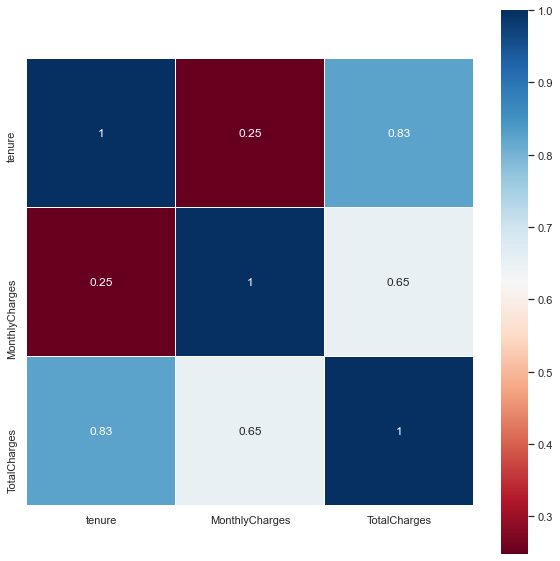

In [15]:
#Positive correlation between this numerical features
corr_matrix(df_data)

In [16]:
#Select numerical df
numerical_df = selectKindFeatures(df_data)

In [17]:
numerical_df.head()

tenure  MonthlyCharges  TotalCharges
0       1           29.85         29.85
1      34           56.95       1889.50
2       2           53.85        108.15
3      45           42.30       1840.75
4       2           70.70        151.65

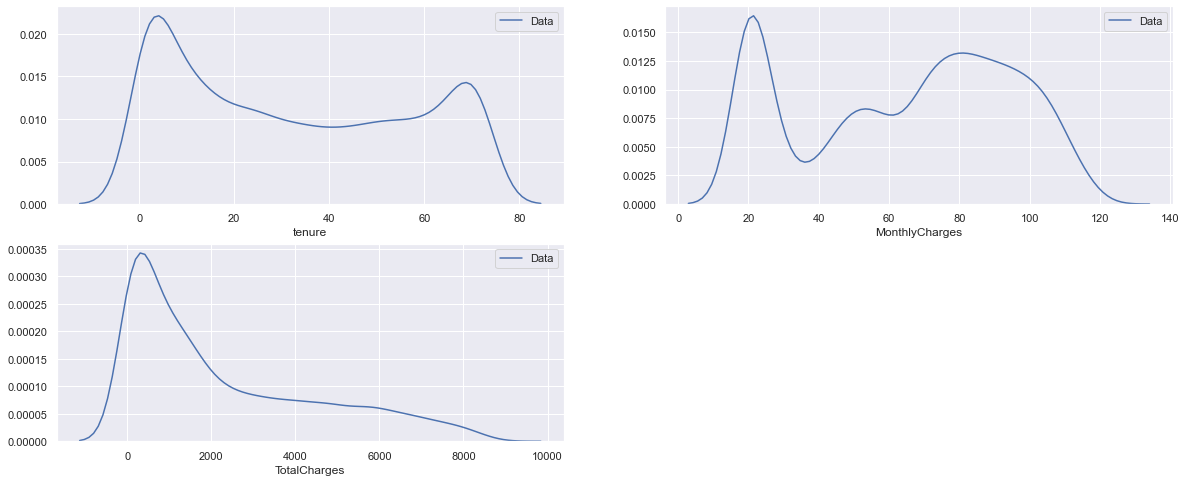

In [18]:
display_distribution(numerical_df,list(numerical_df.columns))

<Figure size 720x720 with 0 Axes>

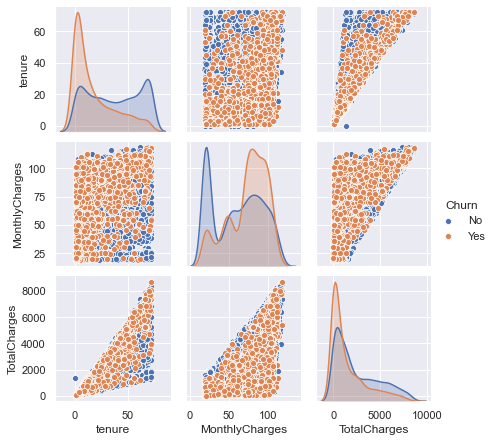

In [19]:
#Correlation features two-by-two in terms of churn rate
#None of this features can separate significantly the customers who churn or not
#But we can see some "trends" like More tenure is lower more the churn rate is high
pair_plot(df=df_data,
          numerical_cols=list(numerical_df.columns),target='Churn')

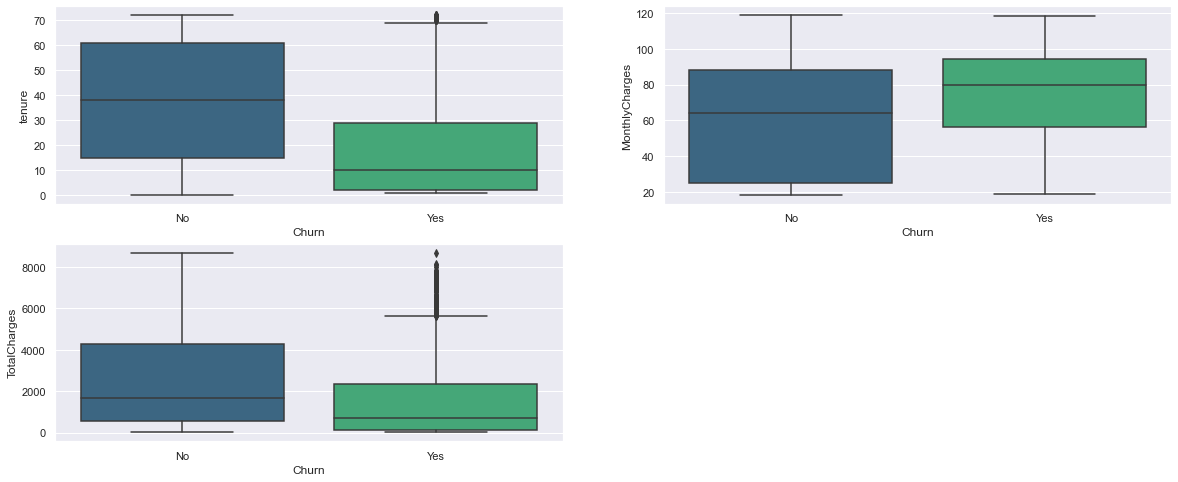

In [20]:
#Boxplot numerical features in terms of the churn value
display_stackedboxplot(df_data,numerical_cols=list(numerical_df.columns),target='Churn')

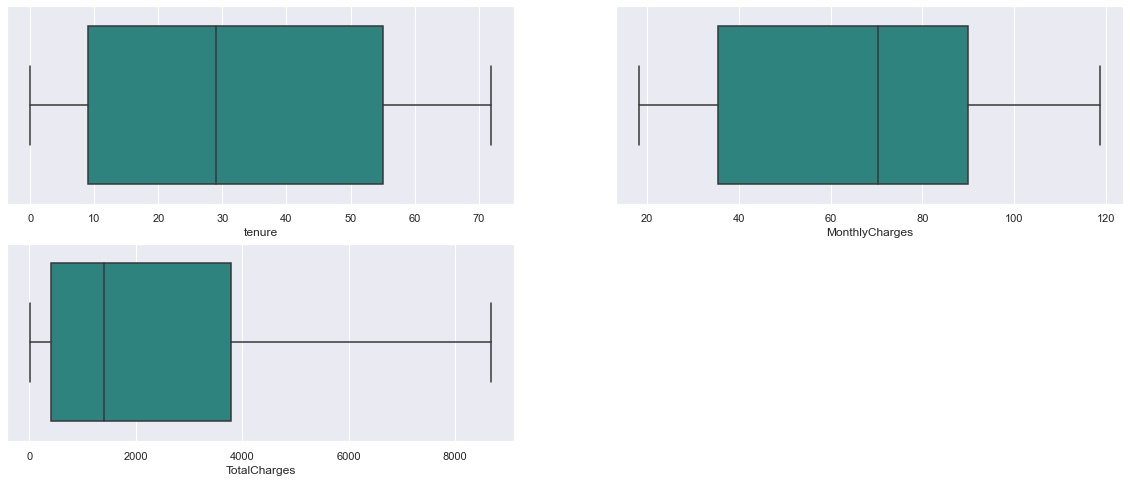

In [21]:
#Simple distribution boxplot of numerical features
display_boxplot(df_data, list(numerical_df.columns))

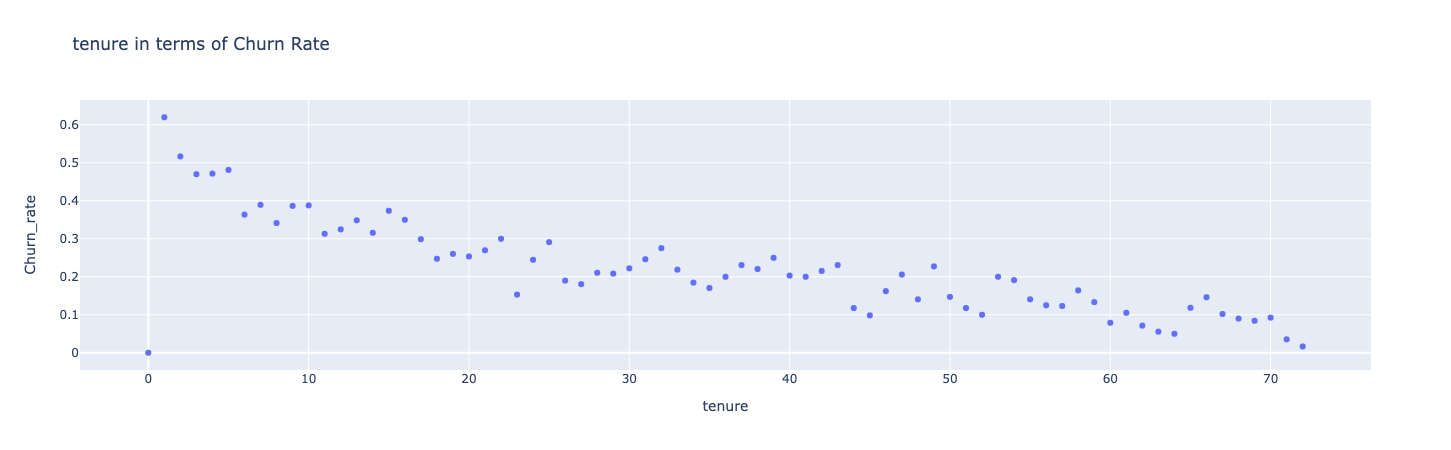

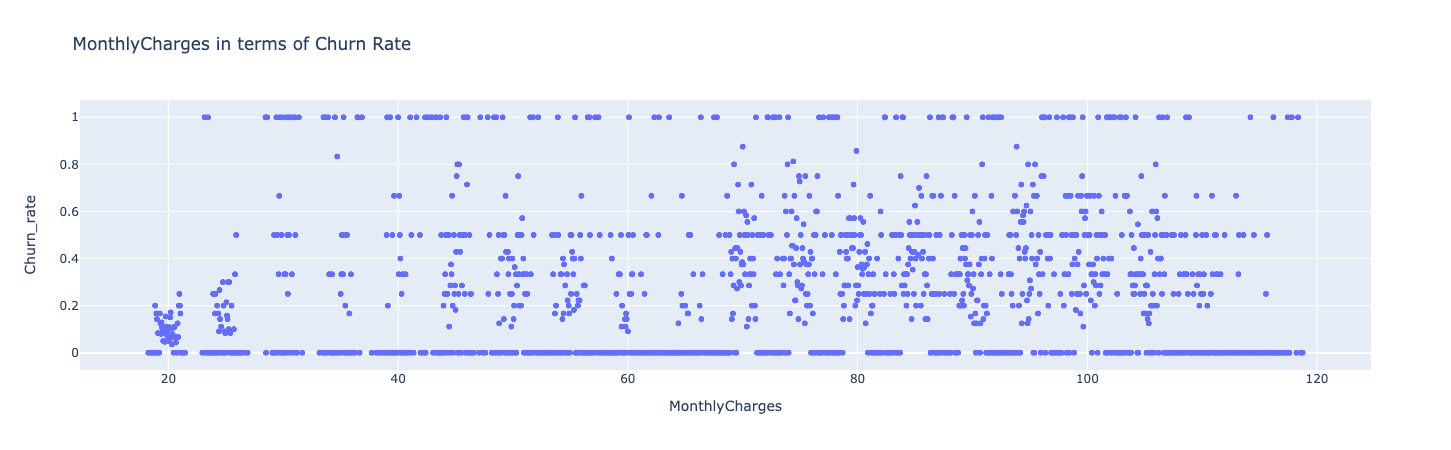

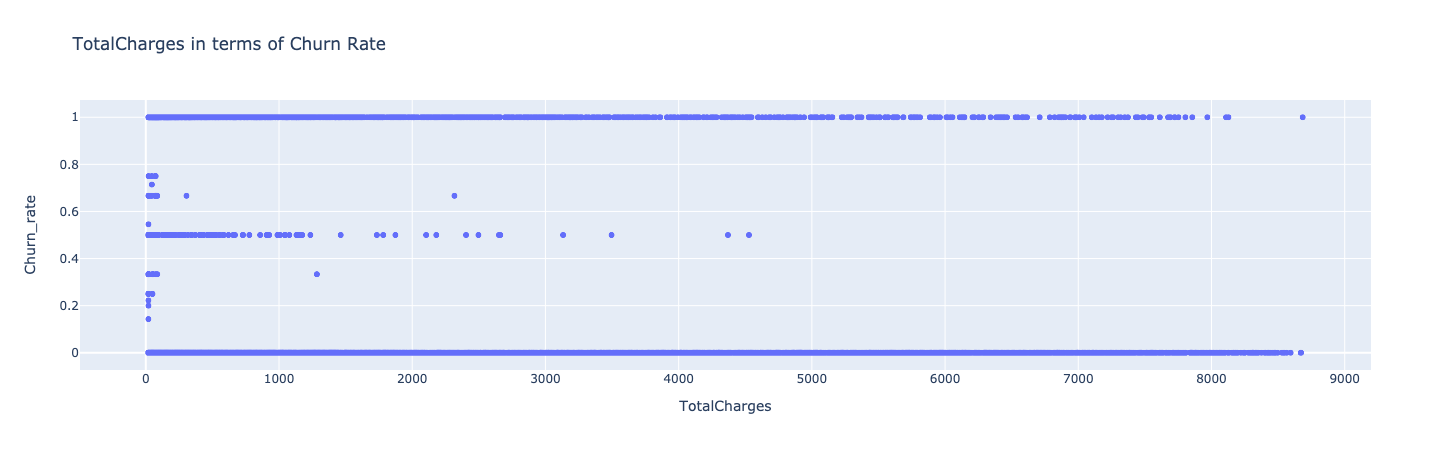

In [22]:
#Compute the churn rate and display numericals features in terms of it
#We can see a clearly trends for tenure More tenure is higher more the churn rate is lower
#But for the other features we can't see trends
for cols in numerical_df.columns:
    display_scatterPlotlyTarget(df_data,cols,'Churn',False)

In [23]:
#Select categorical features
category_df = selectKindFeatures(df_data,kind='object')

In [24]:
category_df.head()

customerID  gender SeniorCitizen Partner Dependents PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling              PaymentMethod Churn
0  7590-VHVEG  Female             0     Yes         No           No  No phone service             DSL             No          Yes               No          No          No              No  Month-to-month              Yes           Electronic check    No
1  5575-GNVDE    Male             0      No         No          Yes                No             DSL            Yes           No              Yes          No          No              No        One year               No               Mailed check    No
2  3668-QPYBK    Male             0      No         No          Yes                No             DSL            Yes          Yes               No          No          No              No  Month-to-month              Yes               Mailed check   Yes
3  7795-CFOCW    Male             0      No         No           No  No phone service             DSL            Yes           No              Yes         Yes          No              No        One year               No  Bank transfer (automatic)    No
4  9237-HQITU  Female             0      No         No          Yes                No     Fiber optic             No           No               No          No          No              No  Month-to-month              Yes           Electronic check   Yes

In [25]:
cols_to_plot = list(category_df.columns)

In [26]:
cols_to_plot.remove('Churn')
cols_to_plot.remove('customerID')

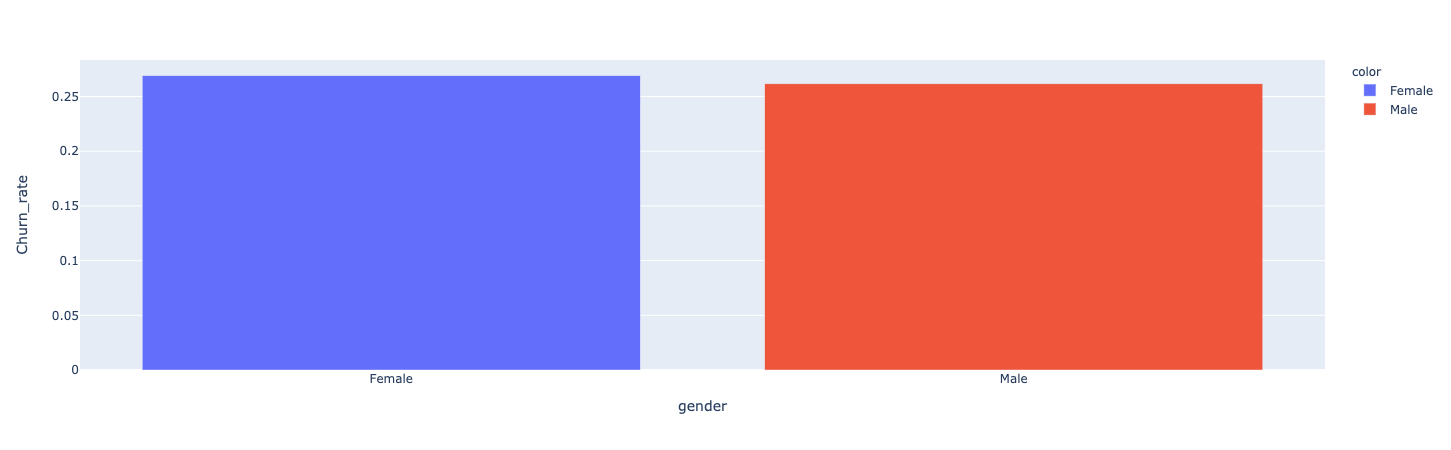

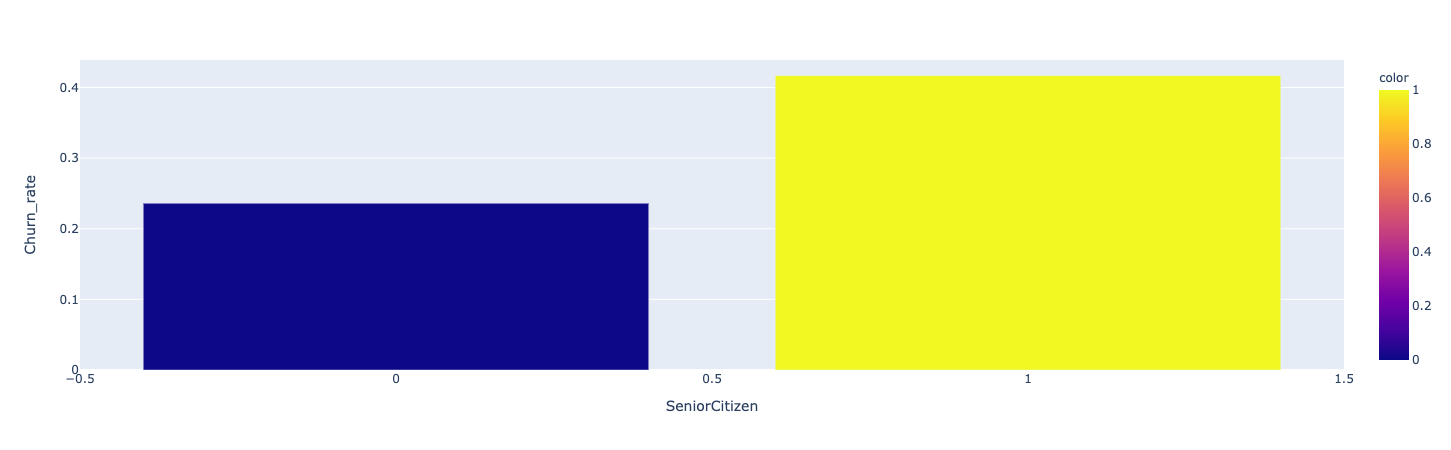

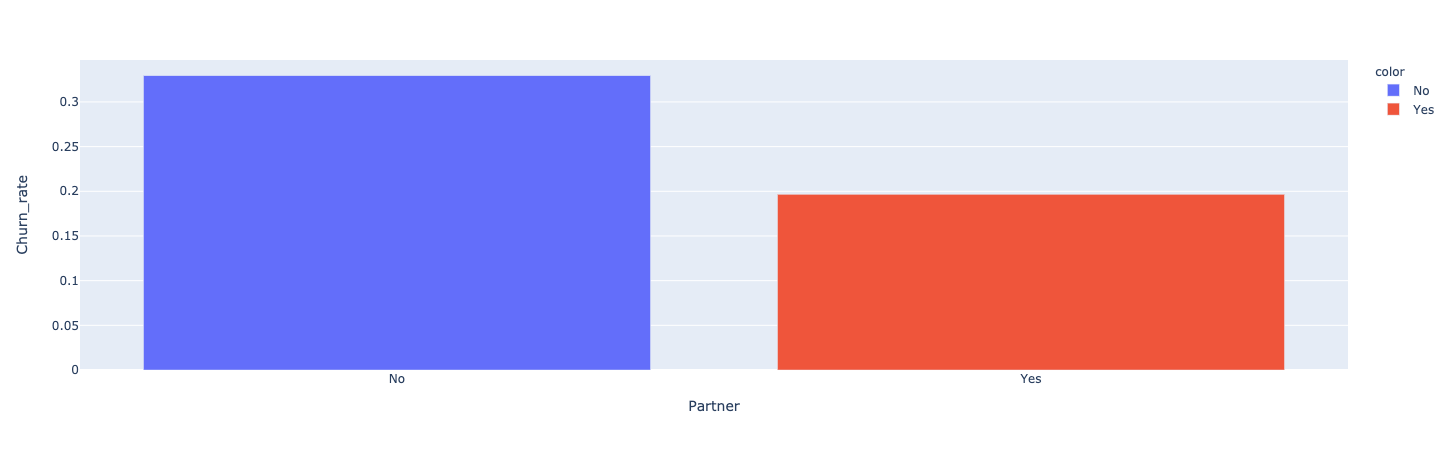

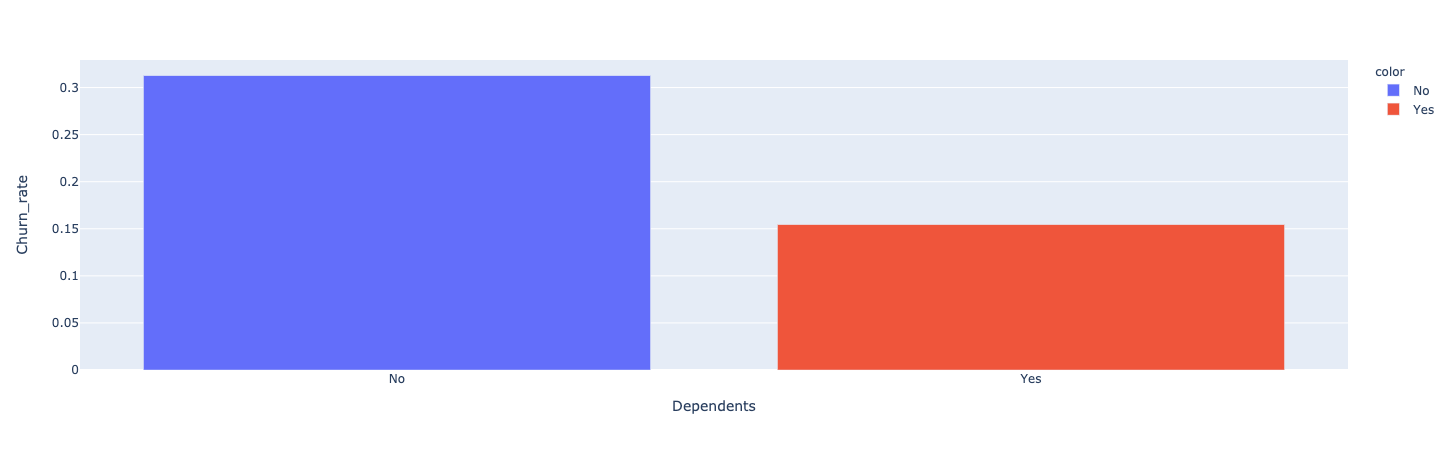

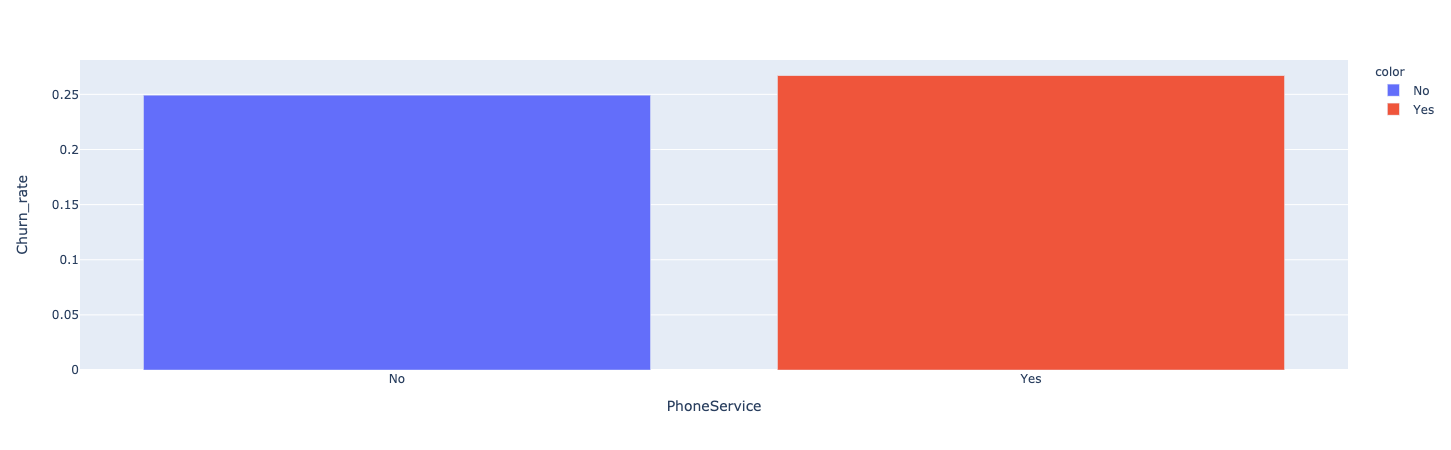

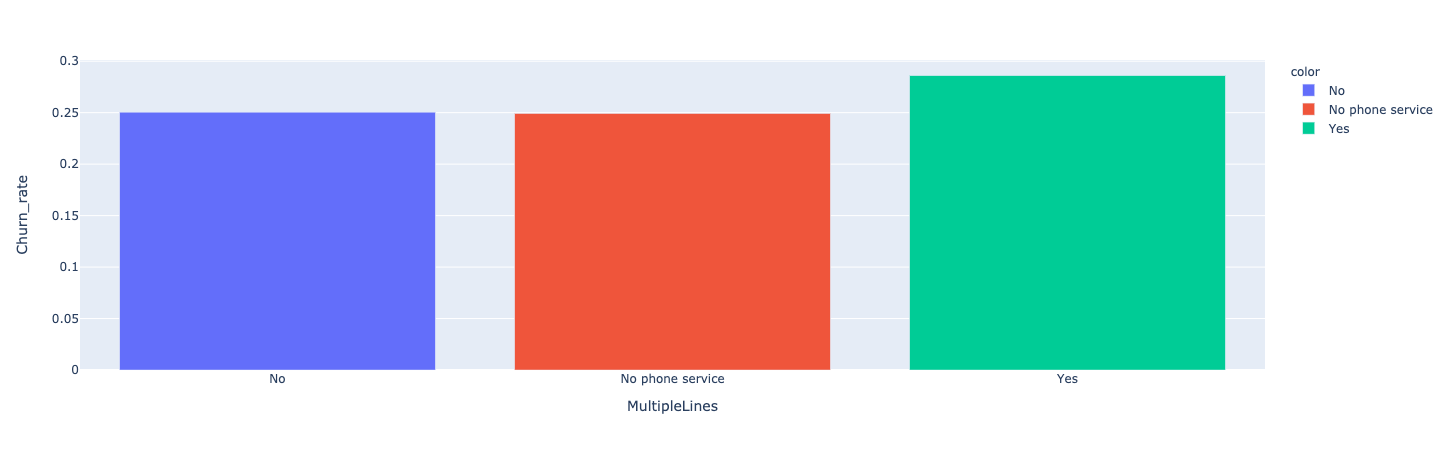

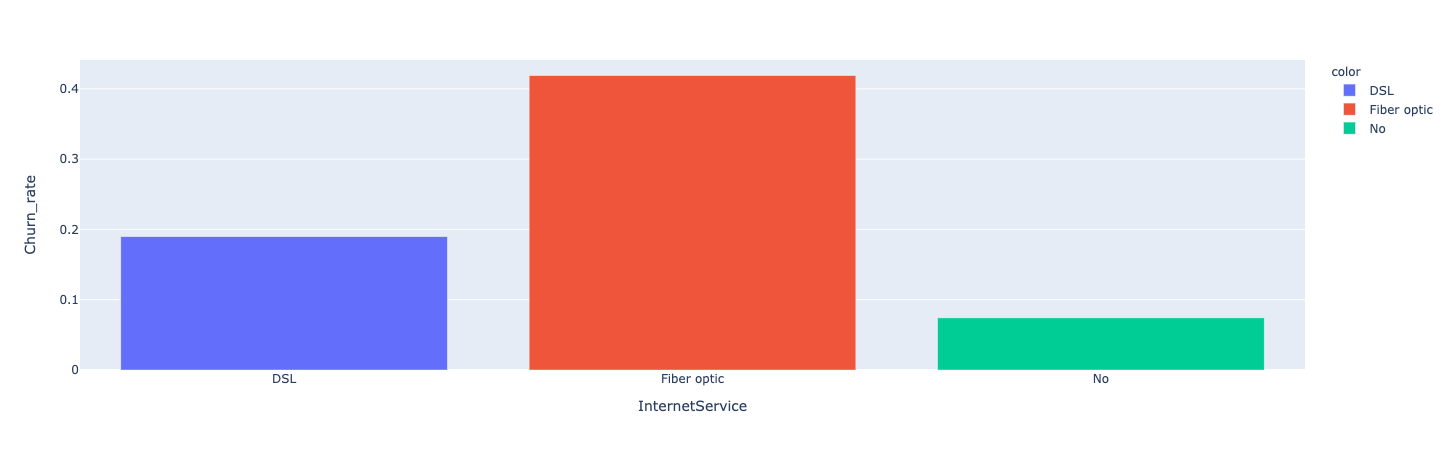

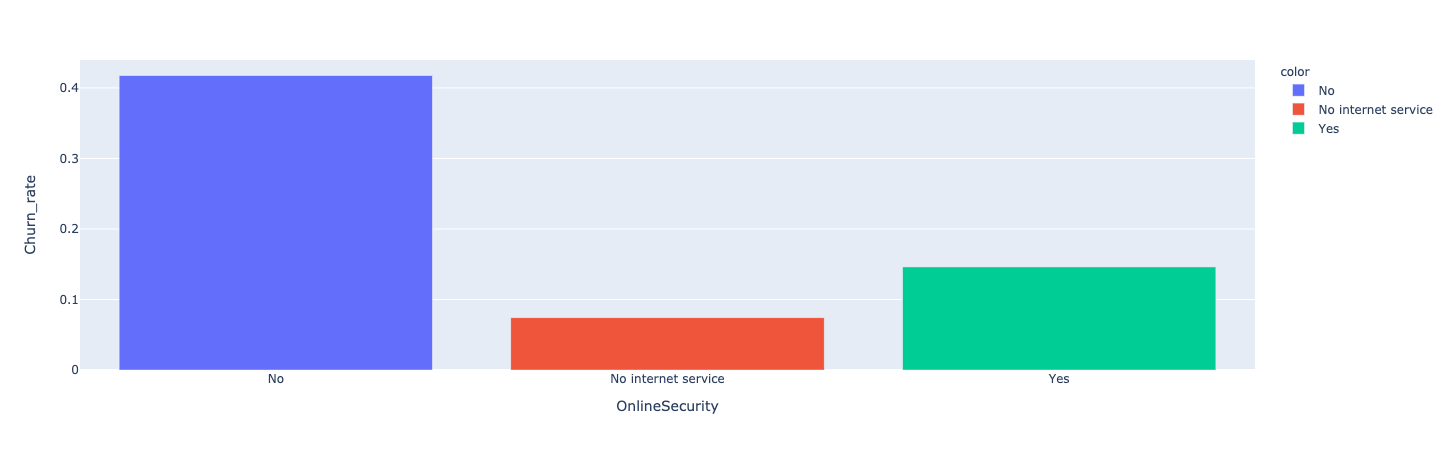

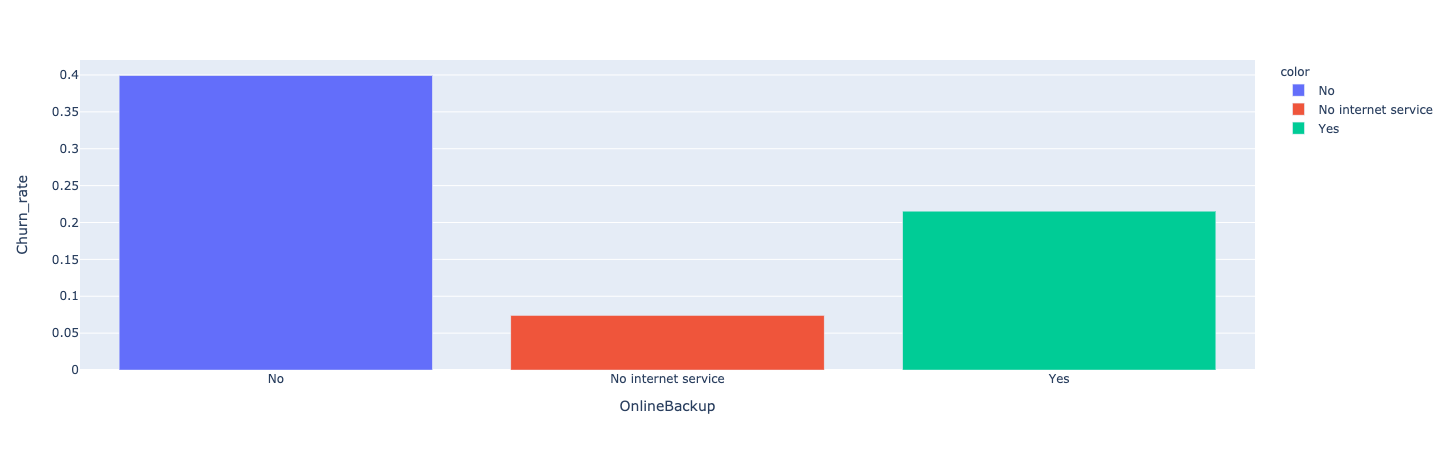

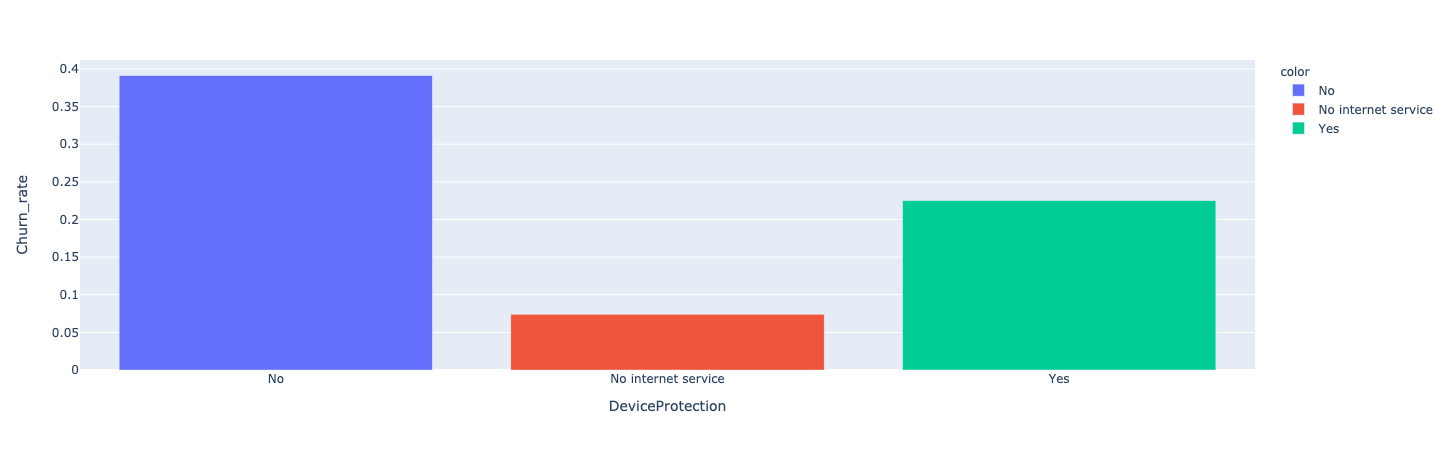

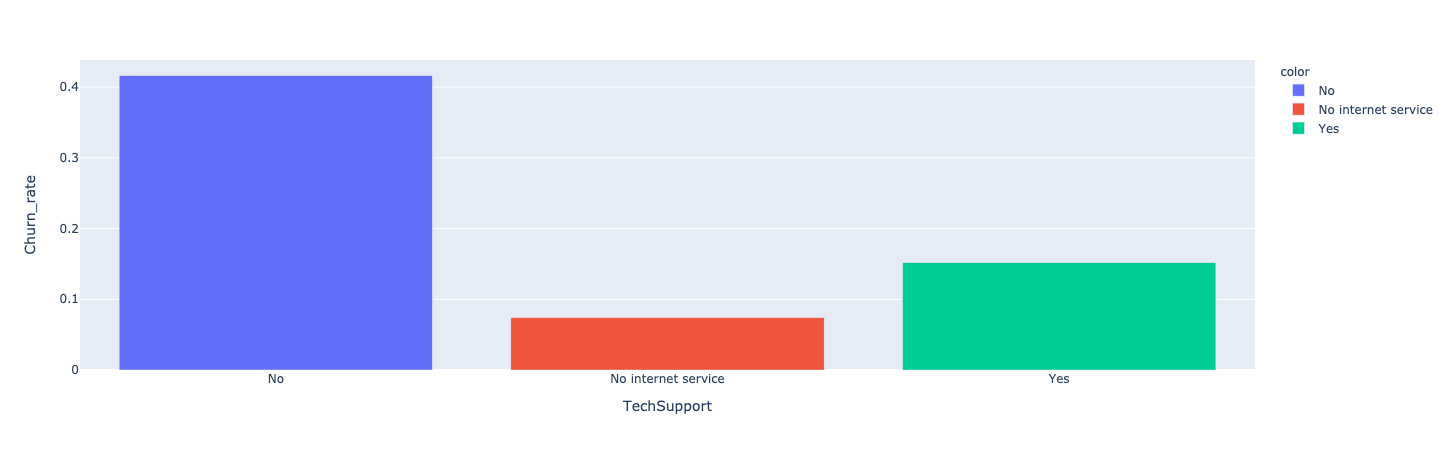

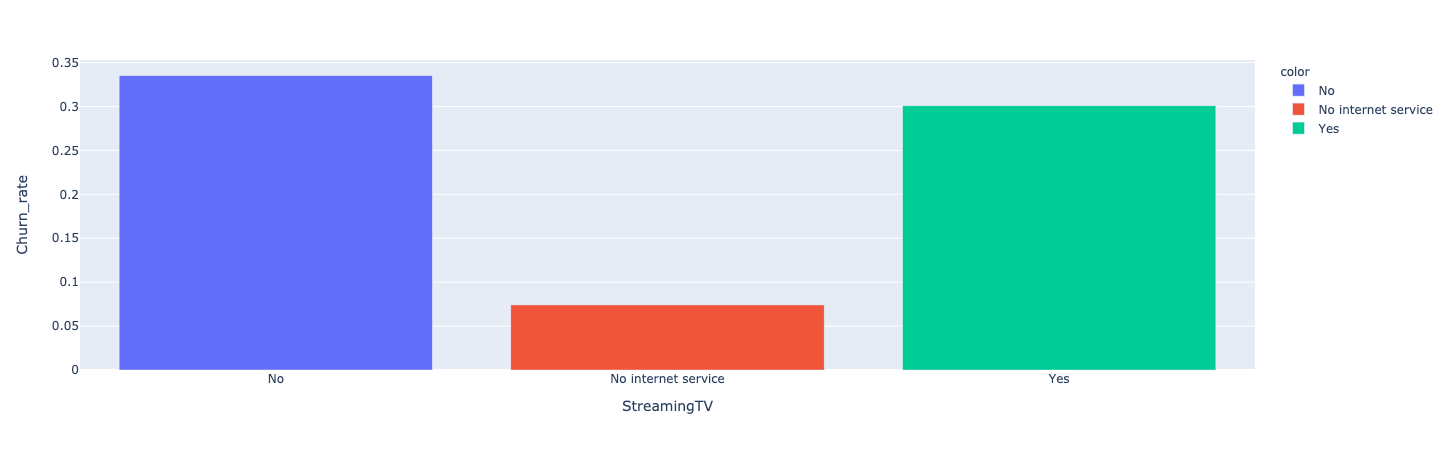

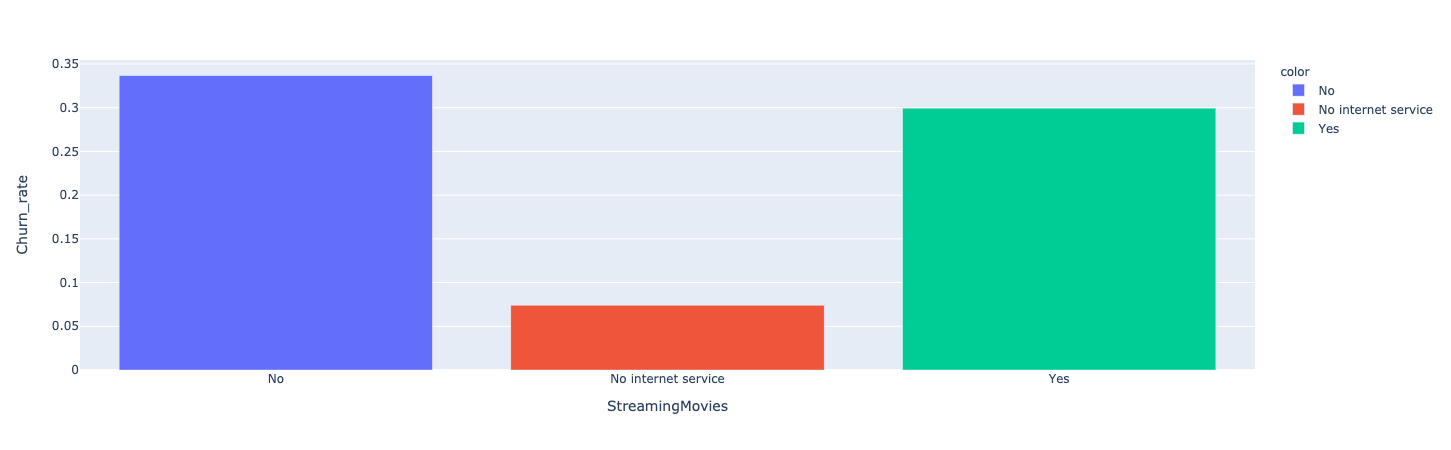

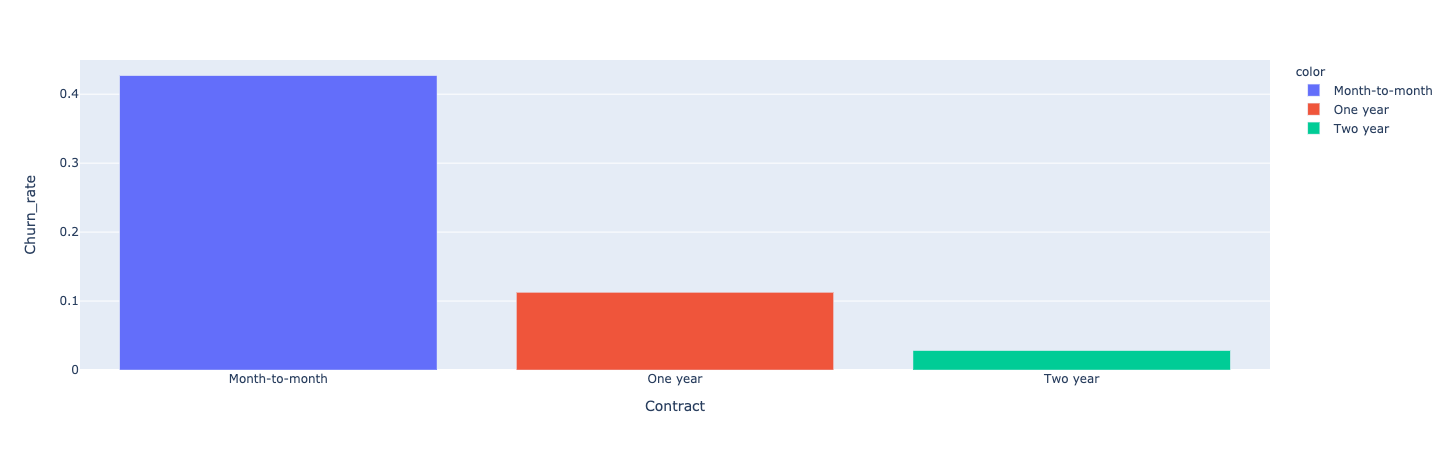

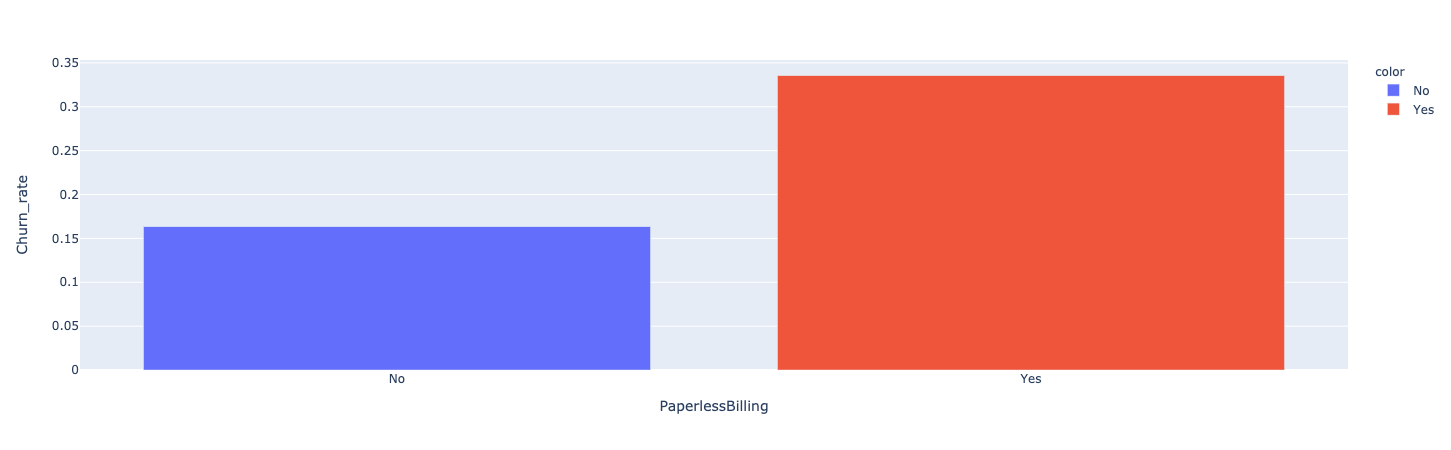

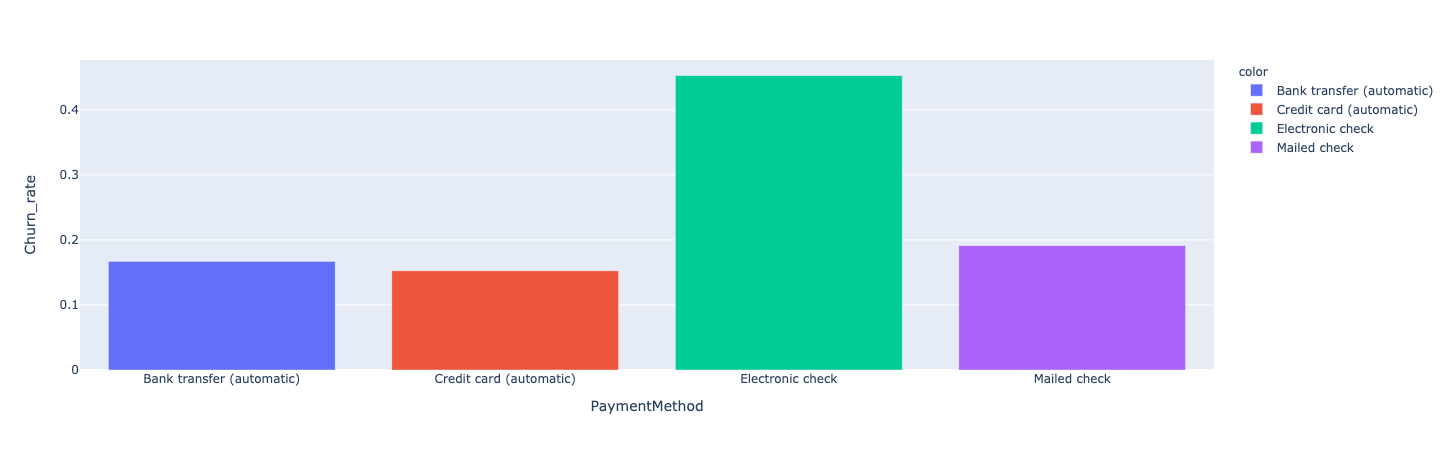

In [27]:
#Categorical features in terms of churn rate
#Same analysis like numerical features we can see some trends
for cols in cols_to_plot:
    display_stackedBarplotPlotly(df_data,cols,'Churn',False)

## Clustering Numerical features

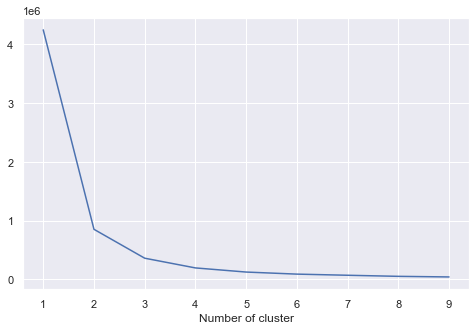

In [28]:
#Create clusters of numerical features
from sklearn.cluster import KMeans

kmeans_inertia={}
tenure_clus = df_data[['tenure']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tenure_clus)
    tenure_clus["clusters"] = kmeans.labels_
    kmeans_inertia[k] = kmeans.inertia_ 
plt.figure(figsize=(8,5))
plt.plot(list(kmeans_inertia.keys()), list(kmeans_inertia.values()))
plt.xlabel("Number of cluster")
plt.show()

In [29]:
#Compute kmeans with 3 class for tenure feature
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['tenure']])
df_data['TenureCluster'] = kmeans.predict(df_data[['tenure']])

In [30]:
#Order the clusters
df_data = order_cluster('TenureCluster','tenure',df_data,False)

In [31]:
df_data.groupby('TenureCluster')['tenure'].describe()

count       mean       std   min   25%   50%   75%   max
TenureCluster                                                           
0              2239.0  63.048682  7.478229  49.0  56.0  64.0  70.0  72.0
1              1926.0  33.854102  8.208706  21.0  26.0  34.0  41.0  48.0
2              2878.0   7.512509  5.977337   0.0   2.0   6.0  12.0  20.0

In [32]:
#Useful when we'll dummies the categorical feature
df_data['TenureCluster'] = np.where(df_data.TenureCluster==0,'High',np.where(df_data.TenureCluster==1,"Mid","Low"))

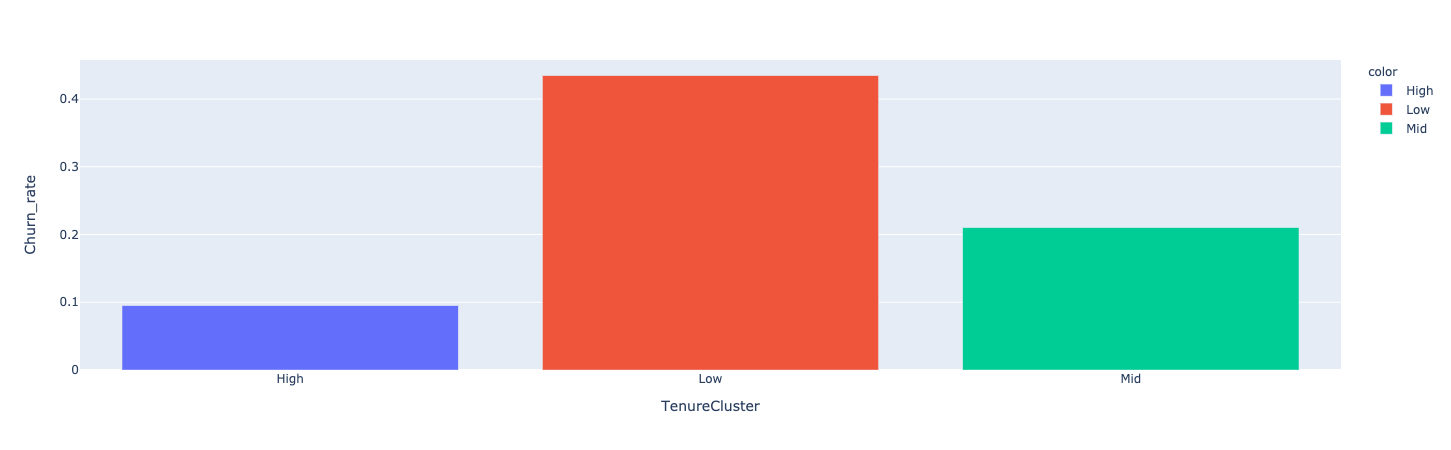

In [33]:
display_stackedBarplotPlotly(df=df_data,col_x='TenureCluster',col_y='Churn',save=False)

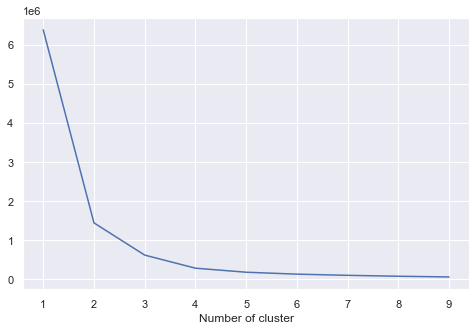

In [34]:
kmeans_inertia={}
mc_clus = df_data[['MonthlyCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(mc_clus)
    mc_clus["clusters"] = kmeans.labels_
    kmeans_inertia[k] = kmeans.inertia_ 
plt.figure(figsize=(8,5))
plt.plot(list(kmeans_inertia.keys()), list(kmeans_inertia.values()))
plt.xlabel("Number of cluster")
plt.show()

In [35]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['MonthlyCharges']])
df_data['MonthlyChargesCluster'] = kmeans.predict(df_data[['MonthlyCharges']])

In [36]:
#Order the clusters
df_data = order_cluster('MonthlyChargesCluster','MonthlyCharges',df_data,False)

In [37]:
df_data.groupby('MonthlyChargesCluster')['MonthlyCharges'].describe().sort_values('count',ascending=False)

count       mean        std    min   25%    50%       75%     max
MonthlyChargesCluster                                                                    
0                      2910.0  94.065395  10.338766  77.90  85.1  93.90  101.9375  118.75
1                      2241.0  61.643284  10.448008  42.60  51.8  61.55   70.7000   77.85
2                      1892.0  23.384619   5.660437  18.25  19.8  20.40   25.0500   42.40

In [38]:
df_data['MonthlyChargesCluster'] = np.where(df_data.MonthlyChargesCluster==0,'High',np.where(df_data.MonthlyChargesCluster==1,"Mid","Low"))

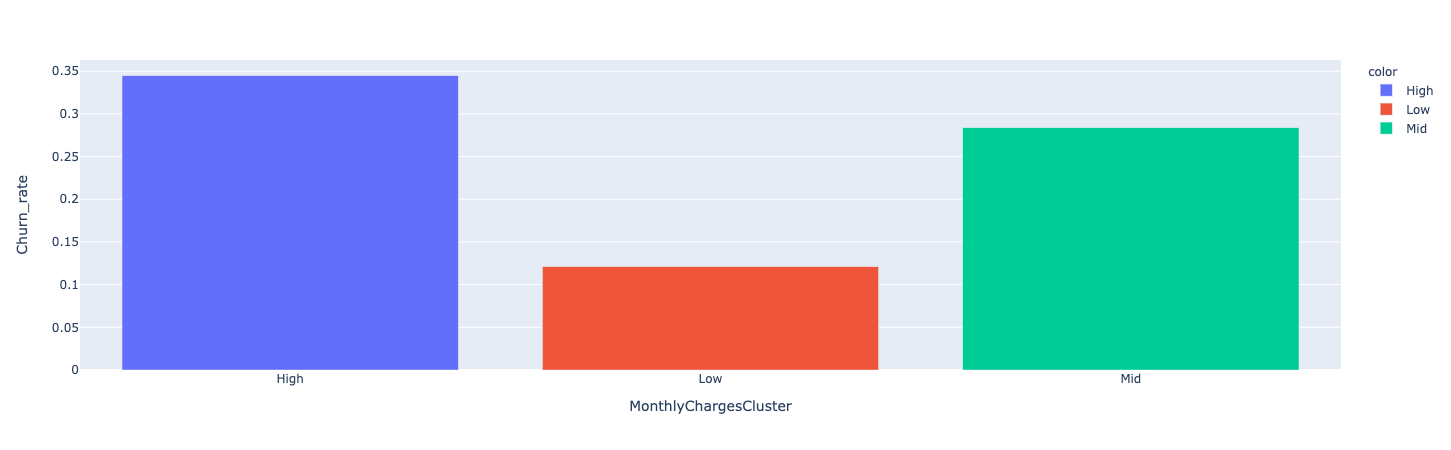

In [39]:
display_stackedBarplotPlotly(df=df_data,col_x='MonthlyChargesCluster',col_y='Churn',save=False)

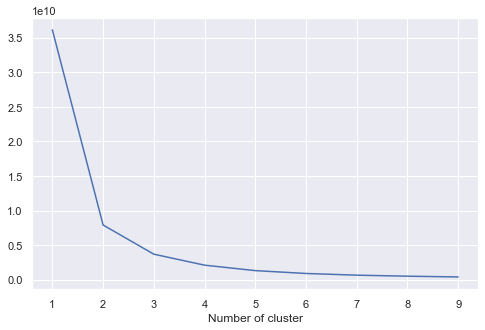

In [40]:
kmeans_inertia={}
tc_clus = df_data[['TotalCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tc_clus)
    tc_clus["clusters"] = kmeans.labels_
    kmeans_inertia[k] = kmeans.inertia_ 
plt.figure(figsize=(8,5))
plt.plot(list(kmeans_inertia.keys()), list(kmeans_inertia.values()))
plt.xlabel("Number of cluster")
plt.show()

In [41]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['TotalCharges']])
df_data['TotalChargesCluster'] = kmeans.predict(df_data[['TotalCharges']])

In [42]:
#Order the clusters
df_data = order_cluster('TotalChargesCluster','TotalCharges',df_data,False)

In [43]:
df_data.groupby('TotalChargesCluster')['TotalCharges'].describe()

count         mean          std     min      25%      50%       75%      max
TotalChargesCluster                                                                               
0                    1259.0  6292.972558  1003.372938  4783.5  5468.70  6145.85  7040.150  8684.80
1                    1611.0  3274.207511   813.372312  1982.1  2550.00  3211.90  3971.325  4779.45
2                    4173.0   688.698820   572.994793    18.8   162.15   540.05  1147.450  1980.30

In [44]:
df_data['TotalChargesCluster'] = np.where(df_data.TotalChargesCluster==0,'High',np.where(df_data.TotalChargesCluster==1,"Mid","Low"))

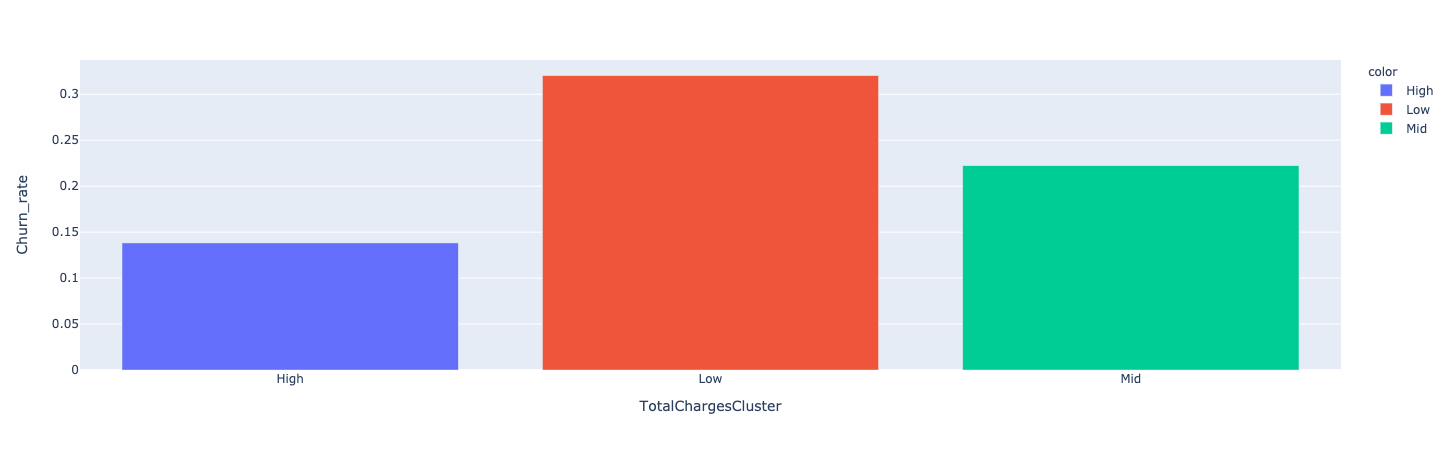

In [45]:
display_stackedBarplotPlotly(df=df_data,col_x='TotalChargesCluster',col_y='Churn',save=False)

In [46]:
category_df = selectKindFeatures(df_data,kind='object')

In [47]:
category_df.head()

customerID  gender SeniorCitizen Partner Dependents PhoneService     MultipleLines InternetService       OnlineSecurity         OnlineBackup     DeviceProtection          TechSupport          StreamingTV      StreamingMovies        Contract PaperlessBilling              PaymentMethod Churn TenureCluster MonthlyChargesCluster TotalChargesCluster
0  7590-VHVEG  Female             0     Yes         No           No  No phone service             DSL                   No                  Yes                   No                   No                   No                   No  Month-to-month              Yes           Electronic check    No           Low                   Low                 Low
1  6713-OKOMC  Female             0      No         No           No  No phone service             DSL                  Yes                   No                   No                   No                   No                   No  Month-to-month               No               Mailed check    No           Low                   Low                 Low
2  7469-LKBCI    Male             0      No         No          Yes                No              No  No internet service  No internet service  No internet service  No internet service  No internet service  No internet service        Two year               No    Credit card (automatic)    No           Low                   Low                 Low
3  8779-QRDMV    Male             1      No         No           No  No phone service             DSL                   No                   No                  Yes                   No                   No                  Yes  Month-to-month              Yes           Electronic check   Yes           Low                   Low                 Low
4  1680-VDCWW    Male             0     Yes         No          Yes                No              No  No internet service  No internet service  No internet service  No internet service  No internet service  No internet service        One year               No  Bank transfer (automatic)    No           Low                   Low                 Low

In [48]:
cols_to_dummies = list(category_df.columns)
cols_to_remove = ['customerID','Churn']
for col in cols_to_remove:
    cols_to_dummies.remove(col)

In [49]:
df_data = pd.get_dummies(data=df_data,columns=cols_to_dummies)

In [51]:
customerID = df_data.customerID.copy()
df_data.drop(['customerID','Churn'],axis=1,inplace=True)

In [72]:
sc = StandardScaler()
df_data[numerical_df.keys()] = sc.fit_transform(df_data[numerical_df.keys()])

In [74]:
df_data.tail()

tenure  MonthlyCharges  TotalCharges  Churn_bool  gender_Female  gender_Male  SeniorCitizen_0  SeniorCitizen_1  Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  PhoneService_No  PhoneService_Yes  MultipleLines_No  MultipleLines_No phone service  MultipleLines_Yes  InternetService_DSL  InternetService_Fiber optic  InternetService_No  OnlineSecurity_No  OnlineSecurity_No internet service  OnlineSecurity_Yes  OnlineBackup_No  OnlineBackup_No internet service  OnlineBackup_Yes  DeviceProtection_No  DeviceProtection_No internet service  DeviceProtection_Yes  TechSupport_No  TechSupport_No internet service  TechSupport_Yes  StreamingTV_No  StreamingTV_No internet service  StreamingTV_Yes  StreamingMovies_No  StreamingMovies_No internet service  StreamingMovies_Yes  Contract_Month-to-month  Contract_One year  Contract_Two year  PaperlessBilling_No  PaperlessBilling_Yes  PaymentMethod_Bank transfer (automatic)  PaymentMethod_Credit card (automatic)  \
7038  1.613701        1.335696      2.323236           0              0            1                1                0           1            0              1               0                0                 1                 0                               0                  1                    0                            1                   0                  1                                   0                   0                0                                 0                 1                    0                                     0                     1               1                                0                0               0                                0                1                   0                                    0                    1                        0                  1                  0                    0                     1                                        0                                      0   
7039  1.247218        1.287504      1.853104           0              1            0                0                1           0            1              1               0                0                 1                 0                               0                  1                    0                            1                   0                  1                                   0                   0                0                                 0                 1                    0                                     0                     1               1                                0                0               0                                0                1                   0                                    0                    1                        1                  0                  0                    0                     1                                        0                                      0   
7040  1.410099        1.269224      2.032720           1              1            0                1                0           1            0              1               0                0                 1                 0                               0                  1                    0                            1                   0                  0                                   0                   1                0                                 0                 1                    0                                     0                     1               1                                0                0               0                                0                1                   1                                    0                    0                        1                  0                  0                    0                     1                                        0                                      1   
7041  1.613701        1.277533      2.243151           0              1            0                1               

## Modelisation